In [72]:
# suggest the library to import math 
import math
class Value:

    def __init__ (self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev= set(_children)
        self._op = _op
        self.label = label
    
    def __repr__ (self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__ (self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # out.grad copies the value to self since it it addition
            other.grad += 1.0 * out.grad

        out._backward = _backward # assigning current node to out for next back propagation node 
        return out
    
    def __mul__ (self, other):
        out =  Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) # nothing but tanh(x)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self): # last node of back propagation
        topo = []
        visited = set()
        def topological_sort(x):
            if x in visited:
                return
            visited.add(x) # adds children to the set
            for child in x._prev: # self._prev = set(_children) of all children
                topological_sort(child)
            topo.append(x)

        topological_sort(self) # sorted based on last node 

        self.grad = 1.0
        for node in reversed(topo):
            node._backward() # calling the function _backward() of each node
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

print(d)

Value(data=4.0, label=d)


In [40]:
d._prev

{Value(data=-6.0, label=e), Value(data=10.0, label=c)}

In [41]:
d._op

'+'

Used this blog to install virutal environment 
https://towardsdatascience.com/demystifying-virtual-environments-in-python-7c0a0b255928

https://medium.com/@shivangisareen/for-anyone-using-jupyter-notebook-installing-packages-18a9468d0c1c

In [7]:
from graphviz import Digraph
#from micrograd.engine import Value
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

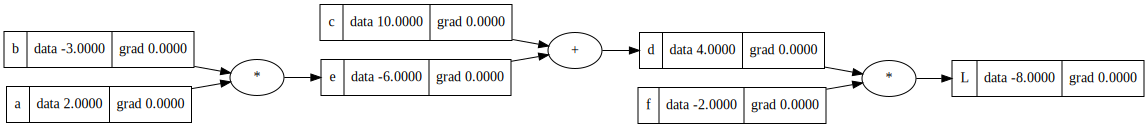

In [8]:
draw_dot(L)

In [31]:
L.grad = 1.0

In [ ]:
# Backpropagation from L to d and f where L = d * f
# what is dL/dd = ? with respect to d = f
# (f(x+h) - f(x)) / h
# ((d+h)*f - d*f) / h
# (d*f + h*f - d*f) / h = h*f / h = f
#  similiarly ,  dL/df = d
# so d.grad = value of f, f.grad = value of d


In [33]:
d.grad = f.data
f.grad = d.data

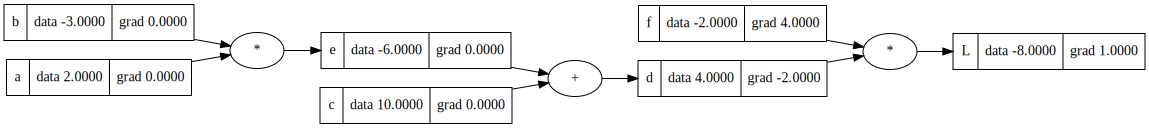

In [34]:
draw_dot(L)

In [ ]:
# Backpropagation from L to c and e thru d and f 
# where d = c + e
# (f(x+h) - f(x)) / h
# dd/dc = ((c+h+e) - (c+e)) / h = 1.0
# dd/de = ((c+e+h) - (c+e)) / h = 1.0

# Know: 
# dL/dd
# dd/dc 

# Want: 
# dL/dc as per the chain rule
# dL/dc = dL/dd * dd/dc 
# c = -2.000 * 1.000 = -2.000
# dL/de = dL/dd * dd/de
# e = -2.000 * 1.000 = 6.000

In [41]:
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0

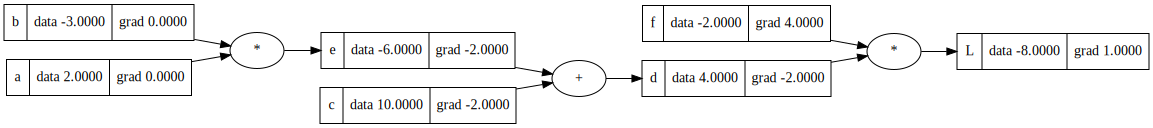

In [42]:
draw_dot(L)

In [ ]:
# We know 
# dL/de = -2.000

# dL/da = (dl/de) * (de/da) = -2.000 * -3.000 = 6.000

# e = a * b so what is de/da
# as we did above for dL/dd and dL/df
# de/da = ((a+h) * b - a * b) / h = b

In [46]:
a.grad = e.grad * b.data 
b.grad = e.grad * a.data

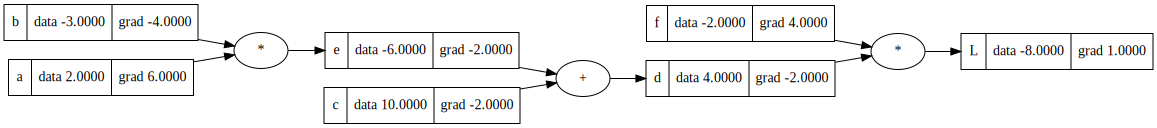

In [47]:
draw_dot(L)

In [52]:
# Try to increment small amount to see how L changes
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# After nudging the data, we want to see how L changes in the forward pass

e = a*b
d = e + c
L = d * f

print(L.data);

-7.286496


plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

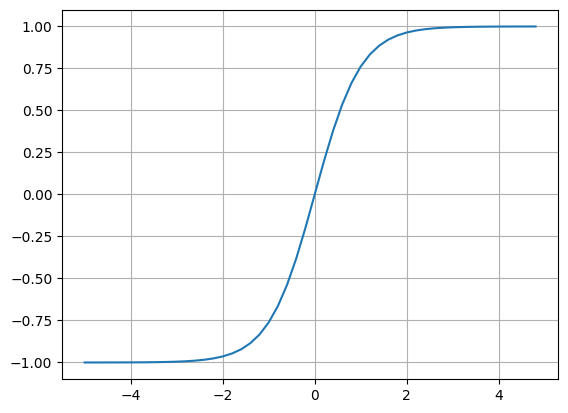

In [4]:
# write appropriate import statement to plot the tanh function 

import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

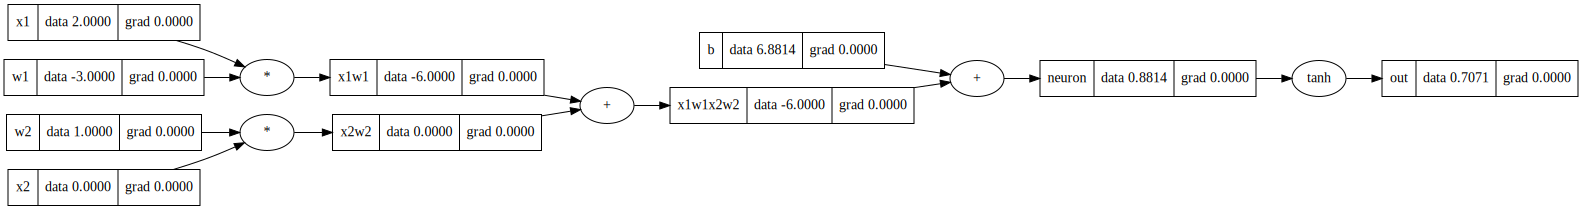

In [15]:
#inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
neuron = x1w1x2w2 + b; neuron.label = 'neuron'
out = neuron.tanh(); out.label = 'out'

draw_dot(out)


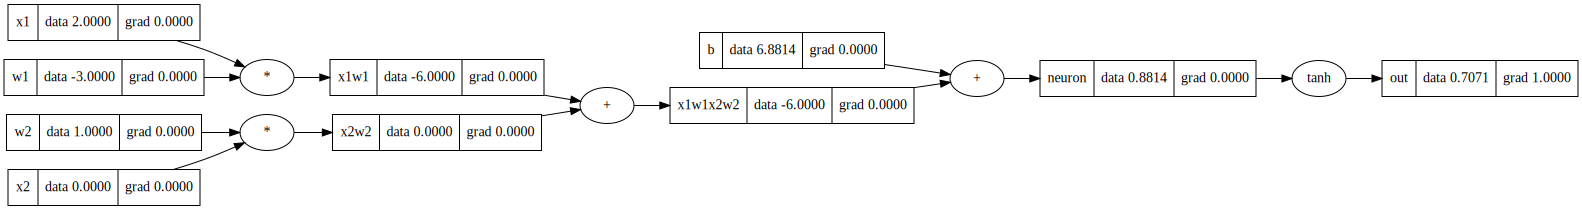

In [16]:
# Backpropagation from out to neuron 
out.grad = 1.0
draw_dot(out)


we need to find the derivate of out = tanh(nueron)
out = tanh(nueron)
do/dn = 1 - tanh(n)**2 

In [17]:
1 - out.data**2 # local derative

0.4999999999999999

In [18]:
neuron.grad = (1 - out.data**2)

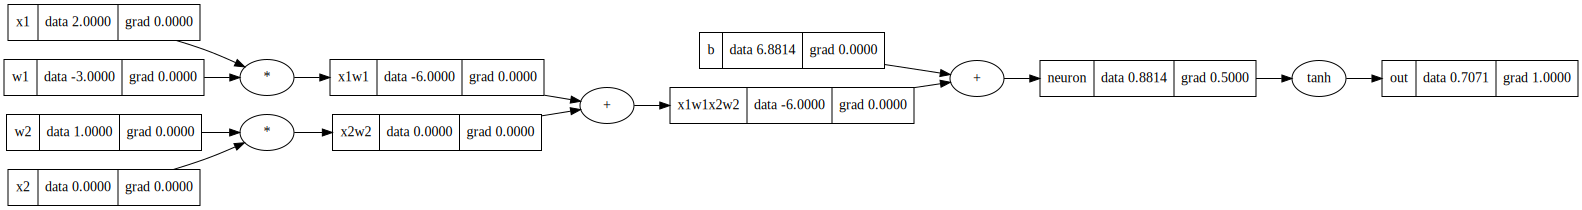

In [20]:
draw_dot(out)

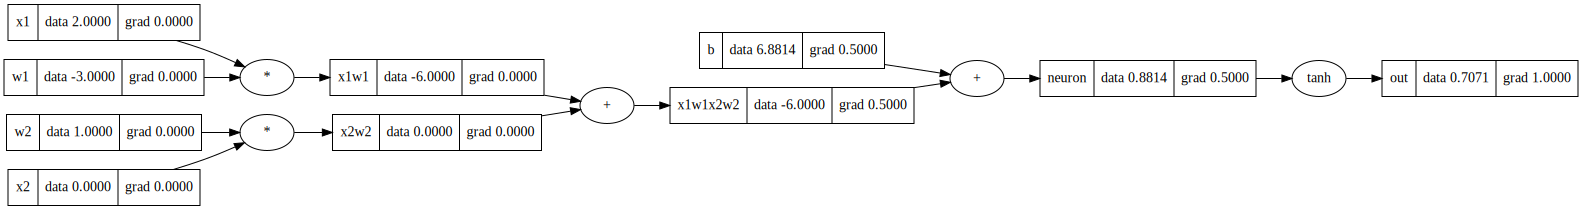

In [21]:
# Backpropagation from neuron to x1w1x2w2 and b
# neuron = x1w1 + x2w2 + b if you recall from the above cell for summing up the inputs and bias the gradient is just gradient of the predecessor node, therefore

x1w1x2w2.grad = neuron.grad
b.grad = neuron.grad
draw_dot(out)

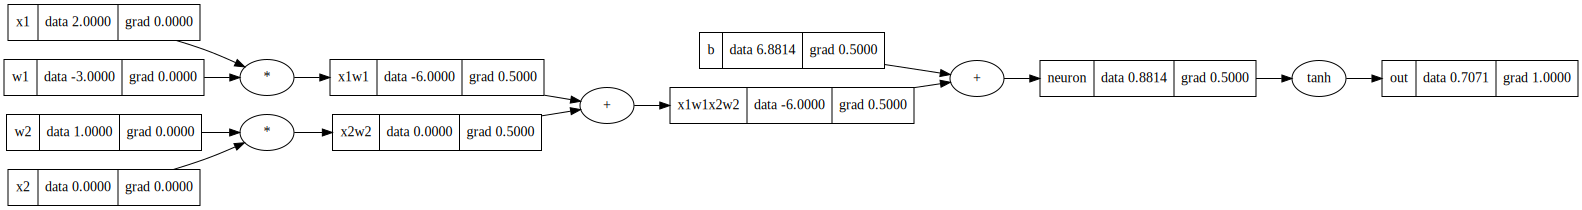

In [22]:
# Backpropagation from x1w1x2w2 to x1w1 and x2w2 is same as above
# x1w1x2w2 = x1w1 + x2w2

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
draw_dot(out)

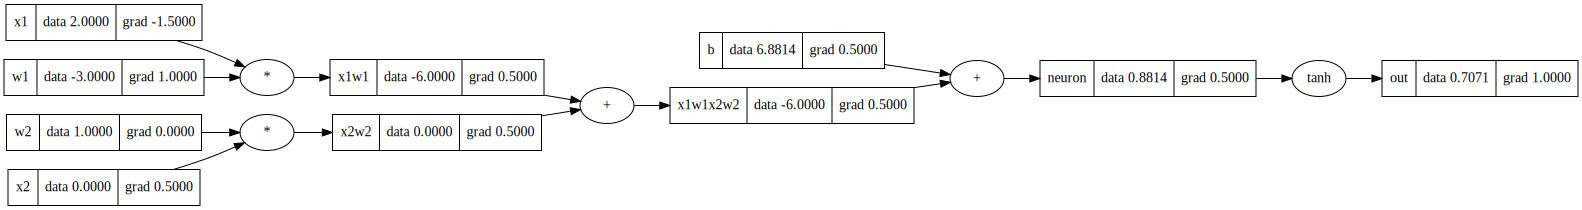

In [23]:
# continuing the backpropagation from x1w1 to x1 and w1, since it is product, the gradient of x1 is the value of w1 and gradient of x1w1. Similarly, gradient of w1 is the value of x1 and gradient of x1w1. Same is the case for x2w2, for x2 and w2 node respectively

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
draw_dot(out)

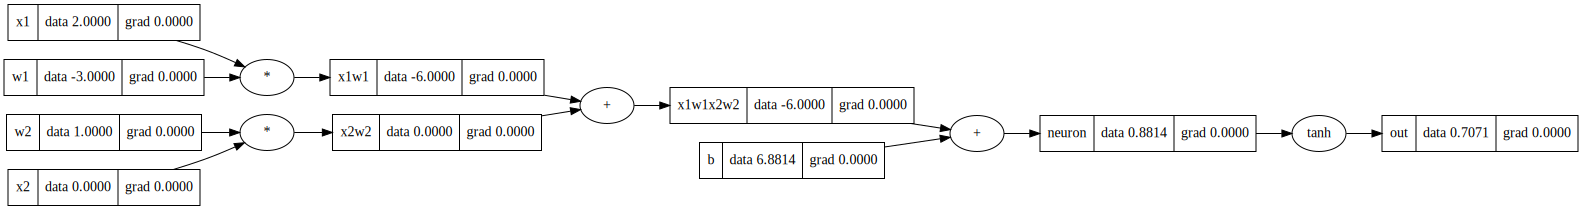

In [42]:
# Reinitialize all the grad to 0 and back propogate the network with the backward functions

#inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
neuron = x1w1x2w2 + b; neuron.label = 'neuron'
out = neuron.tanh(); out.label = 'out'

draw_dot(out)

In [43]:
# Since self.grad = 0, we need to set it to 1.0 the first time we call backward
out.grad = 1.0

In [54]:
out._backward()
neuron._backward()
b._backward() # b is a leaf node, so it has no _backward method assigned lambda: None
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

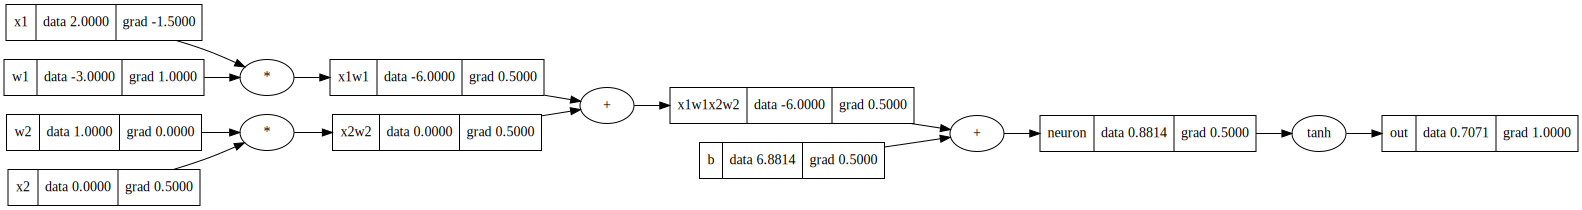

In [55]:
draw_dot(out)

In [56]:
# Topological sort is a way to order the nodes in a graph such that if node A comes before node B in the ordering, then A is never an ancestor of B. This is useful for backpropagation, because you always want to compute the gradient of a node before you compute the gradient of any of its ancestors.

topo = []
visited = set()
def topological_sort(x):
    if x in visited:
        return
    visited.add(x) # adds children to the set
    for child in x._prev: # self._prev = set(_children) of all children
        topological_sort(child)
    topo.append(x)

topological_sort(out)
topo 

[Value(data=1.0, label=w2),
 Value(data=0.0, label=x2),
 Value(data=0.0, label=x2w2),
 Value(data=2.0, label=x1),
 Value(data=-3.0, label=w1),
 Value(data=-6.0, label=x1w1),
 Value(data=-6.0, label=x1w1x2w2),
 Value(data=6.881373587019543, label=b),
 Value(data=0.8813735870195432, label=neuron),
 Value(data=0.7071067811865476, label=out)]

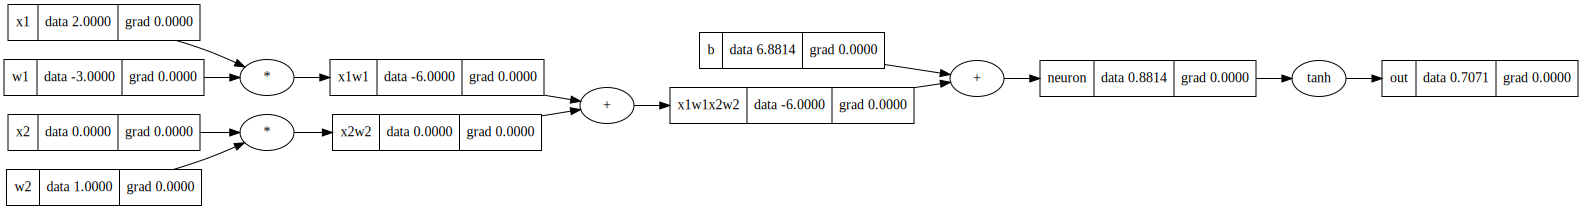

In [60]:
# Now we can eliminate the need for the _backward method by just iterating through the nodes in reverse topological order and calling their backward methods.

# Reinitialize all the grad to 0 and back propogate the network with the backward functions

#inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
neuron = x1w1x2w2 + b; neuron.label = 'neuron'
out = neuron.tanh(); out.label = 'out'

draw_dot(out)

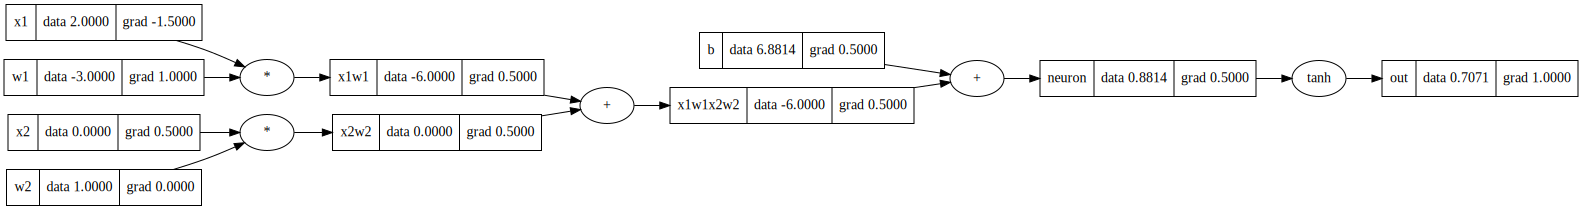

In [65]:
out.grad = 1.0

topo = []
visited = set()
def topological_sort(x):
    if x in visited:
        return
    visited.add(x) # adds children to the set
    for child in x._prev: # self._prev = set(_children) of all children
        topological_sort(child)
    topo.append(x)

topological_sort(out)

for node in reversed(topo):
    node._backward()

draw_dot(out)

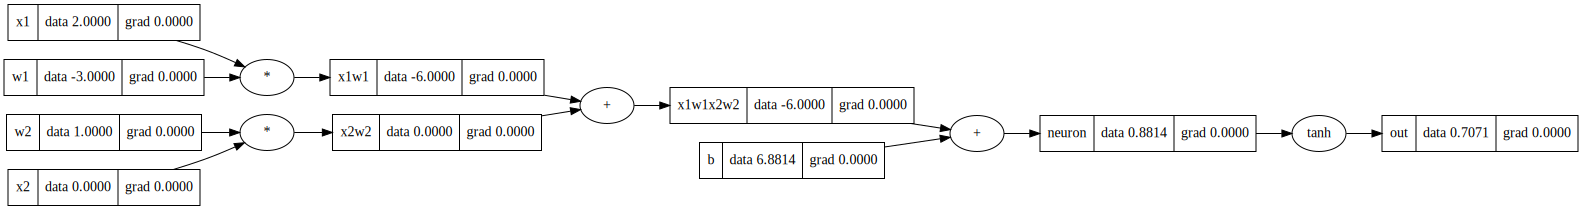

In [68]:
# Reinitialize all the grad to 0 and back propogate the network with the backward functions

#inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
neuron = x1w1x2w2 + b; neuron.label = 'neuron'
out = neuron.tanh(); out.label = 'out'

draw_dot(out)

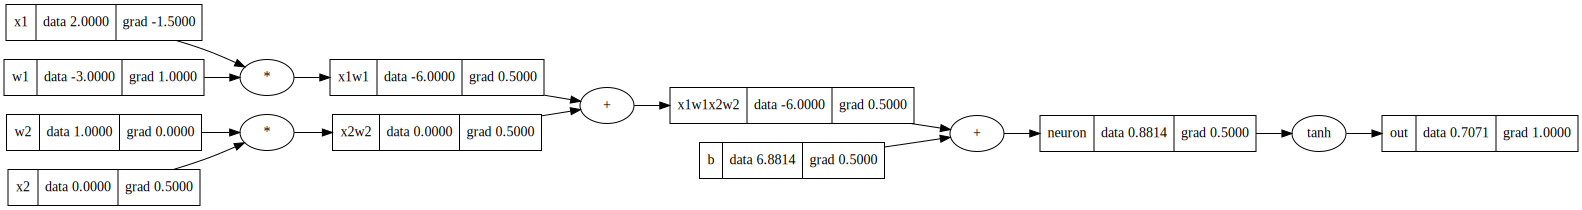

In [69]:
out.backward()
draw_dot(out)

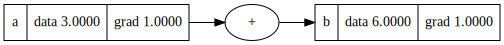

In [70]:
# There is bad bug for example 
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)
# The gradient should be 2 for a, because we are adding twice ; but it is 1.0. There are two arrow in the node b. The gradient is being added twice. We need to fix this bug.

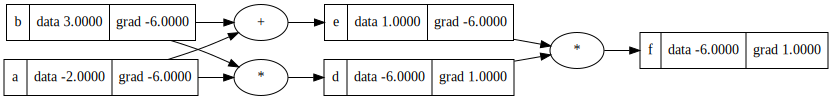

In [71]:
# Another example of the bug
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'
f.backward()
draw_dot(f)

In [ ]:
# from f to d works fine, but when we go to e it will overwrite the gradient of d. We need to fix this bug. 
# Solution: is accumulate the gradient instead of overwriting it with the new gradient.

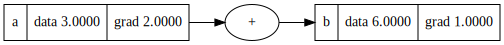

In [73]:
# Now after the bug fix
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

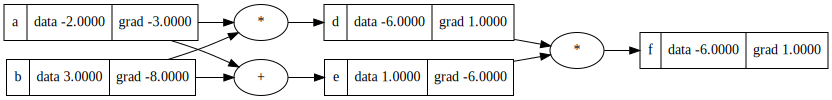

In [74]:
# Another example of the bug
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'
f.backward()
draw_dot(f)

In [51]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    a.data = a.data + h
    b = Value(-3.0, label='b')
    # b.data = b.data + h
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    e.data = e.data
    d = e + c
    d.label = 'd'
    d.data = d.data
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print ((L2 - L1)/h)

lol()

6.000000000000227
